# Part 4: Final Transit Parameters

Import Python libraries

In [1]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee
import corner
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Upload the Excel Files containing Transit Fit Parameters

In [2]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')

Define a planetary system.

In [3]:
class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.omega = 0.0
        self.per = per
        self.per_err = per_err
        
        self.mass = mass
        self.mass_err = mass_err
        self.radius = radius
        self.radius_err = radius_err
        
        self.teff = teff
        self.teff_err = teff_err
        self.logg = logg
        self.feh = feh
    
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. Rp needs to be in Earth radii
         
        self.u1 = 0.0 # Claret
        self.u2 = 0.0 # Claret
        self.diffld = 0.0
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.transWindow = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
          
        self.optimize4 = np.empty(0)
        
    def Print(self):
        print("Star {}".format(self.name))

Number of targets that this code will analyze

In [4]:
num = 12

About "tr_window:" Array containing estimates for transit windows (in days). To find them, I initially used a transit window of 20 hours (very big) for all the targets and plotted the folded LC. After visually inspecting it, I made my guesses. Given that these are essentially transit_range*2 (and transit_range is already in days), I chose the transit windows to be twice the range of the transit (I also estimated the range visually, so this process is not perfect. However, it's enough for the code to work and yield good results).

In [5]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.07, 0.08, 0.12, 0.15, 0.08, 0.18, 0.15])
tr_window = transit_range+transit_range # In days

In [6]:
targets = []

for i in range(0, num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    #Logg
    logg = physical["logg"][i]
    feh = physical["feh"][i]
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)

    u1 = 0.0
    u2 = 0.0
    
    # This will upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']

    trange = transit_range[i]
    twind = tr_window[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC)
    
    star.transRange = trange
    star.transWindow = twind 
     
    targets.append(star)

Get the quadratic coefficients for the standard Kepler limb-darkening profile. Model: Claret 2011. 

In [9]:
import kplr
from kplr.ld import get_quad_coeffs

def quadraticLD(star): 
    getmu1, getmu2 = get_quad_coeffs(star.teff, star.logg, star.feh)
    return getmu1, getmu2

for star in targets:
    mu1, mu2 = quadraticLD(star)
    print "Star", star.name, ":", "u1 =", mu1, "u2 =", mu2, "u1-u2 =", mu1-mu2
    star.u1 = mu1
    star.u2 = mu2
    star.diffld = mu1-mu2

Star 201516974 : u1 = 0.7867 u2 = -0.0114 u1-u2 = 0.7981
Star 201920032 : u1 = 0.4089 u2 = 0.2556 u1-u2 = 0.1533
Star 205924614 : u1 = 0.678 u2 = 0.0894 u1-u2 = 0.5886
Star 205985357 : u1 = 0.4415 u2 = 0.2396 u1-u2 = 0.2019
Star 206029314 : u1 = 0.4906 u2 = 0.1813 u1-u2 = 0.3093
Star 206038483 : u1 = 0.4089 u2 = 0.2556 u1-u2 = 0.1533
Star 206061524 : u1 = 0.6656 u2 = 0.0853 u1-u2 = 0.5803
Star 206082454 : u1 = 0.3858 u2 = 0.2711 u1-u2 = 0.1147
Star 206155547 : u1 = 0.3277 u2 = 0.2981 u1-u2 = 0.0296
Star 206245553 : u1 = 0.3643 u2 = 0.2807 u1-u2 = 0.0836
Star 206247743 : u1 = 0.5362 u2 = 0.1609 u1-u2 = 0.3753
Star 206311743 : u1 = 0.5508 u2 = 0.1646 u1-u2 = 0.3862


Run the code

In [10]:
def processStar(star):
    
    #Clean LC (remove points above 3 sigma)
    goodP = intro(star) 
    
    # Print old values for the period and midtransit time 
    old_per =  star.per
    old_t0 = star.midts
    print "Old period:", old_per
    print "Old t0:", old_t0
    print ""    
    
    # Upload best guesses for period and overall t0    
    info = np.loadtxt('3_'+star.name+'finalp0t0.txt', skiprows=1)
    star.per = info[0,0]
    star.midts = info[1,0]
    
    #Print new values for the period and midtransit time
    print "New period: ", star.per
    print "New t0: ", star.midts
    print ""
   
    mark_transits(star)  #Identify transits in the data 
    new_error = outliers(star) #remove >3sigma outliers for the new LC and give new std
    
    print "New standard dev:", new_error
    old_error = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1) [8] # Upload old stdv
    print "Old standard dev:", old_error
    
    transit_window(star, goodP) #Create phase-folded LC with new values of period and overall t0
    out_transit(star)
    oot_fit(star)

In [11]:
def intro(star): #Clean LC (remove points above 3 sigma)
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

In [12]:
def outliers(star):
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux + 3*errorLC
    star.fluxLC = star.fluxLC[goodPoints]
    star.timeLC = star.timeLC[goodPoints]
    new_err = np.std(star.fluxLC)
    star.error_foldedLC = new_err
    return new_err

In [13]:
def out_transit(star):
    # print "Range of the transit (visual estimate):", star.transRange
    dataBool = np.abs(star.dt) >= star.transRange # If true, point is outside of the transit.
    out = (star.t_trans <= star.transRange) & (star.t_trans >= star.transRange) # Boolean array. Tells which points are outside the transit.
    return out

In [14]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -30
    maxepoch = 30
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits

In [15]:
def transit_window(star, goodP): #Select the points that are "transit_window" hours to the left & right of the transit.
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    window = star.transWindow # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0, len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans # time w.r.t. midtransit. 
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

For each individual transit: perform a linear fit to the out-of-transit regions.

In [16]:
def oot_fit(star): 
    
    corFlux = star.f_trans
    
    for i in range(0, len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            #corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
            
        else: 
            star.transits[i] = 0.0
   
    # ------- Fix length of star.transits vector (if necessary) ------- 
    
    new_a = np.empty(0)
     
    for k in range(0, len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a
    
    # ------- Fix length of star.flag, star.f_trans, star.t_trans, and star.dt vectors (if necessary)
    
    sumPoints = 0
    
    for i in range(0, len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.t_trans[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.f_trans[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.t_trans = t_trans 
    star.f_trans = f_trans 
    star.dt = dT
    
    # Divide the "light curve" of each transit by the fit obtained in the previous window.
    
    corFlux2 = star.f_trans
    
    for i in range(0, len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux2[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) 

In [17]:
new_targets = np.empty(0)

for i in range(0, len(targets)):    
    if (targets[i].name != "205985357") and (targets[i].name != "206247743") and (targets[i].name != "206311743"):
        new_targets = np.append(new_targets, targets[i])
        
for star in new_targets:
    print "Star ", star.name
    
print len(new_targets)

#  205985357: False Positive
#  206247743: False Positive 
#  206311743: False Positive

Star  201516974
Star  201920032
Star  205924614
Star  206029314
Star  206038483
Star  206061524
Star  206082454
Star  206155547
Star  206245553
9



 ** Star  201516974 **

Old period: 36.7098909842
Old t0: 1986.80555162

New period:  36.72503659
New t0:  1986.79440402

New standard dev: 0.000786259116833
Old standard dev: 0.00090608313


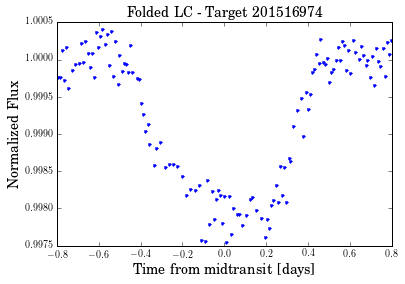

------------------------------------------------------------

 ** Star  201920032 **

Old period: 28.2716715297
Old t0: 2000.205774

New period:  28.2716926045
New t0:  2000.20375062

New standard dev: 0.000264378530054
Old standard dev: 0.00035930069


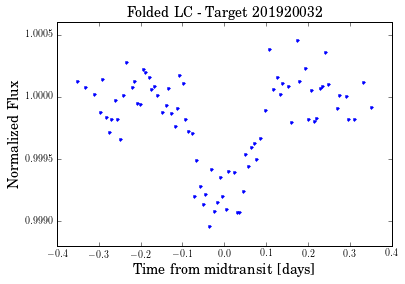

------------------------------------------------------------

 ** Star  205924614 **

Old period: 2.8493410352
Old t0: 2150.424485

New period:  2.8492854753
New t0:  2150.42286341

New standard dev: 0.000911775381207
Old standard dev: 0.00148136477


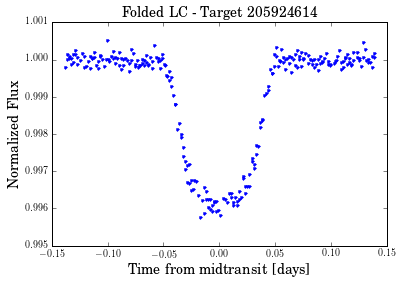

------------------------------------------------------------

 ** Star  206029314 **

Old period: 7.0260433213
Old t0: 2148.06875

New period:  7.0263836189
New t0:  2148.06473542

New standard dev: 0.0113899502161
Old standard dev: 0.01357206052


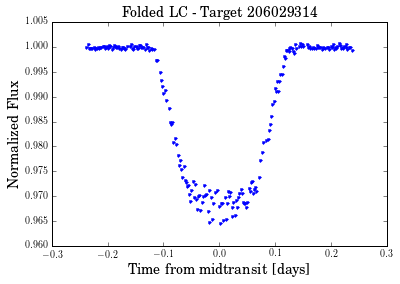

------------------------------------------------------------

 ** Star  206038483 **

Old period: 3.00258097652
Old t0: 2149.05976

New period:  3.0026252211
New t0:  2149.05988737

New standard dev: 0.00168995870224
Old standard dev: 0.00208533311


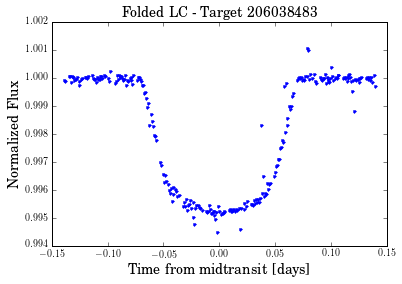

------------------------------------------------------------

 ** Star  206061524 **

Old period: 5.87969688905
Old t0: 2153.323933

New period:  5.8793793165
New t0:  2153.32436576

New standard dev: 0.00283757688138
Old standard dev: 0.00351527683


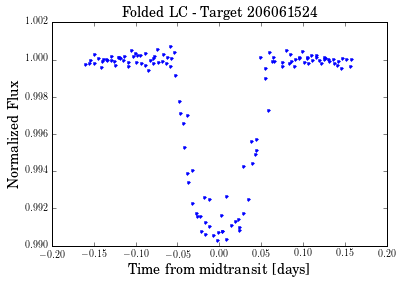

------------------------------------------------------------

 ** Star  206082454 **

Old period: 29.6259825117
Old t0: 2160.54021572

New period:  29.62590845
New t0:  2160.540277

New standard dev: 0.00046728531521
Old standard dev: 0.00056777951


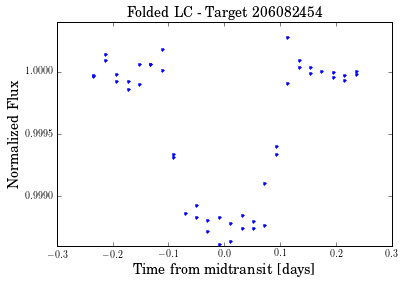

------------------------------------------------------------

 ** Star  206155547 **

Old period: 24.3872033754
Old t0: 2152.884148

New period:  24.3873658957
New t0:  2152.88459268

New standard dev: 0.009103404721
Old standard dev: 0.01036184501


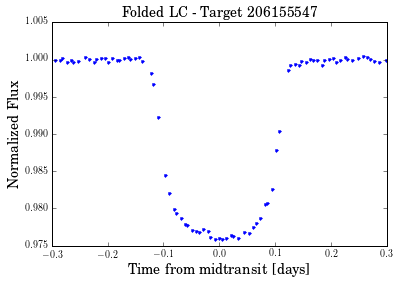

------------------------------------------------------------

 ** Star  206245553 **

Old period: 7.49495298435
Old t0: 2154.672782

New period:  7.4954812744
New t0:  2154.67255725

New standard dev: 0.000209208148046
Old standard dev: 0.0002698681


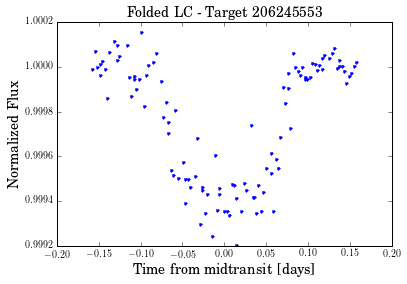

------------------------------------------------------------



In [18]:
print "WARNING: If old & new period are the same, run again the code from the beginning!"
print ""
for star in new_targets:
    print " ** Star ", star.name, "**"
    print ""
    processStar(star)
    
    # Plot the phase-folded light curve: star.dt vs. star.f_trans
    fig = plt.figure() 
    plt.plot(star.dt, star.f_trans,'.') 
    plt.title('Folded LC - Target ' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.xlabel('Time from midtransit [days]', fontsize = 14)
    plt.savefig('4_'+star.name+'final_foldedLC.jpg', dpi=800)
    plt.show()
    
    folded_time = star.dt
    folded_flux = star.f_trans
    
    argsorts = np.argsort(folded_time)
    
    folded_time = folded_time[argsorts]
    folded_flux = folded_flux[argsorts]
    
    l = len(folded_time)
    error = np.empty(l, dtype = object)
    
    for i in range(0,l):
        error[i] = 0.0001
        
    np.savetxt('4_folded' + star.name +'.csv', np.transpose([folded_time, folded_flux, error]), 
               delimiter=' ', fmt='%0.6f')
    plt.show()
    
    print "------------------------------------------------------------"
    print ""

## Fit Phase-Folded Light Curves

Likelihood function that will help me find the best transit parameters and their uncertainties



In [19]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    """
    
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = np.abs(pmass), radius = pradius))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period = period, t0 = pt0, b = np.abs(pb), e = ecc)
    s.add_body(body)
    
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp = tKep, tol = 1e-8, maxdepth = 4)
    ftheo = ftheo - 1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

Define the probability function as likelihood * prior.

In [20]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
   
    if (0 <= pb < 0.9) and (pdepth > 0) and (0 <= sigma) and (0 < pradius < 2) and (pmass > 0) and (0.4 < sumLD < 1.0):
        return 0.0
    
    return -np.inf

In [21]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

Optimization for target 201516974 ...
Optimization terminated successfully.
         Current function value: -942.961019
         Iterations: 879
         Function evaluations: 1357
-> Optimal parameters:
      Depth: 0.00271751833174
      Impact parameter b: 0.899533936536
      Initial transit time: 0.00082387717287
      Sum of quadratic LD coefficients: 0.740164461632
      Sigma (additional white noise term): 1.66256784235e-10
      Mass (Earth units): 0.0111186275555
      Radius (Earth units): 1.51722615862
      Out-of-transit Flux: 1.0000220203



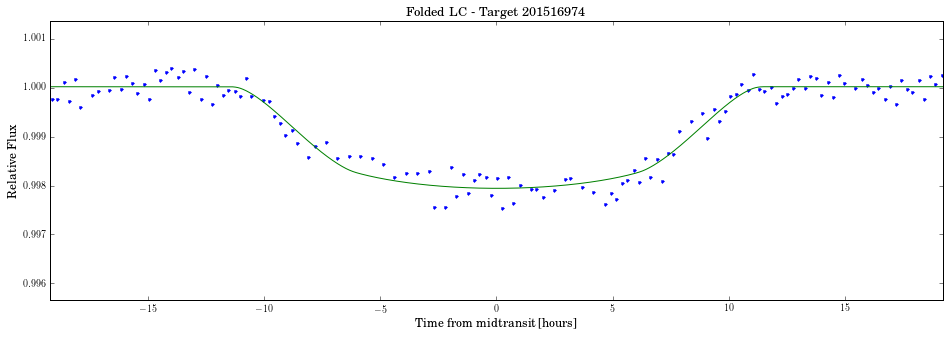

Optimization for target 201920032 ...
Optimization terminated successfully.
         Current function value: -667.253783
         Iterations: 523
         Function evaluations: 822
-> Optimal parameters:
      Depth: 0.000592460446765
      Impact parameter b: 0.0167855463211
      Initial transit time: -0.000578256473632
      Sum of quadratic LD coefficients: 0.999391815655
      Sigma (additional white noise term): 2.10796369624e-06
      Mass (Earth units): 0.995058046583
      Radius (Earth units): 0.809194384782
      Out-of-transit Flux: 1.00002119169



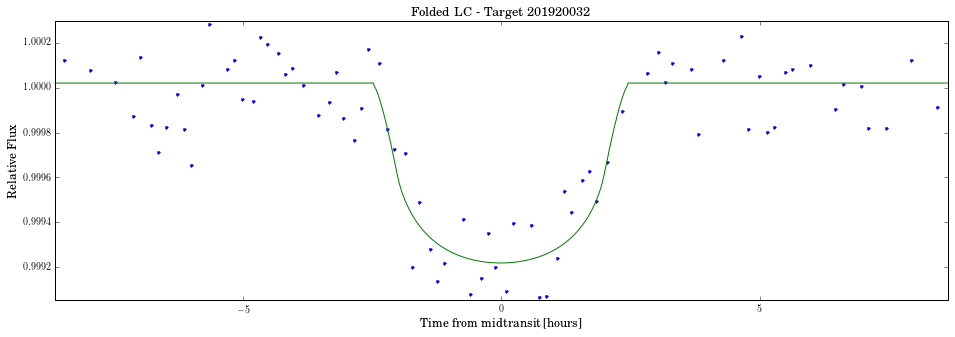

Optimization for target 205924614 ...
Optimization terminated successfully.
         Current function value: -1746.179968
         Iterations: 580
         Function evaluations: 870
-> Optimal parameters:
      Depth: 0.00302519638264
      Impact parameter b: 0.10981115186
      Initial transit time: -1.02926748022e-06
      Sum of quadratic LD coefficients: 0.758184840149
      Sigma (additional white noise term): 8.22099482524e-07
      Mass (Earth units): 0.70421754217
      Radius (Earth units): 0.669997829823
      Out-of-transit Flux: 0.999998429073



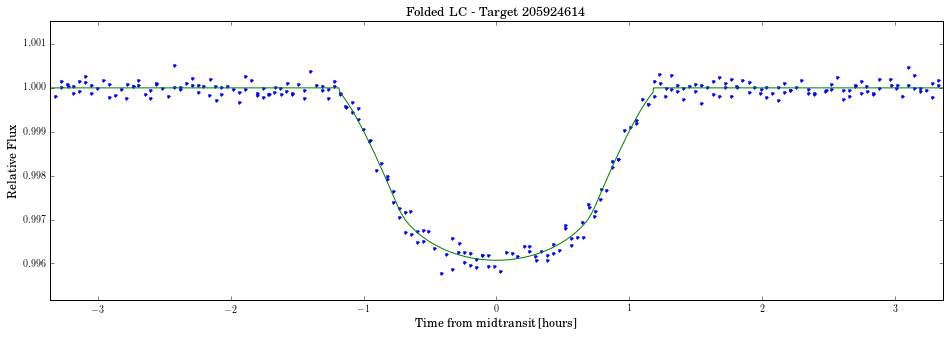

Optimization for target 206029314 ...
Optimization terminated successfully.
         Current function value: -944.347705
         Iterations: 595
         Function evaluations: 911
-> Optimal parameters:
      Depth: 0.0271122490298
      Impact parameter b: 0.0262564120485
      Initial transit time: 0.00148658551799
      Sum of quadratic LD coefficients: 0.400163121414
      Sigma (additional white noise term): 0.000157761044664
      Mass (Earth units): 0.772699163972
      Radius (Earth units): 1.05926780875
      Out-of-transit Flux: 0.99868490816



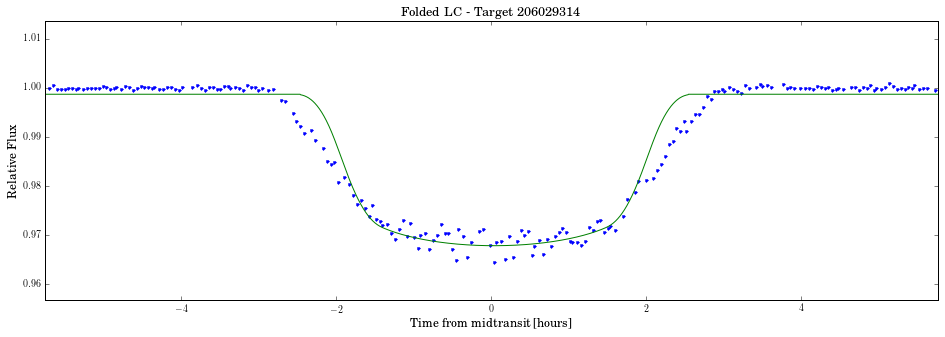

Optimization for target 206038483 ...
Optimization terminated successfully.
         Current function value: -1611.264535
         Iterations: 528
         Function evaluations: 804
-> Optimal parameters:
      Depth: 0.00390410053669
      Impact parameter b: 3.40288841849e-06
      Initial transit time: -0.000754796048387
      Sum of quadratic LD coefficients: 0.692151231987
      Sigma (additional white noise term): 2.38613651392e-06
      Mass (Earth units): 0.973632339171
      Radius (Earth units): 1.08528412478
      Out-of-transit Flux: 0.999995249934



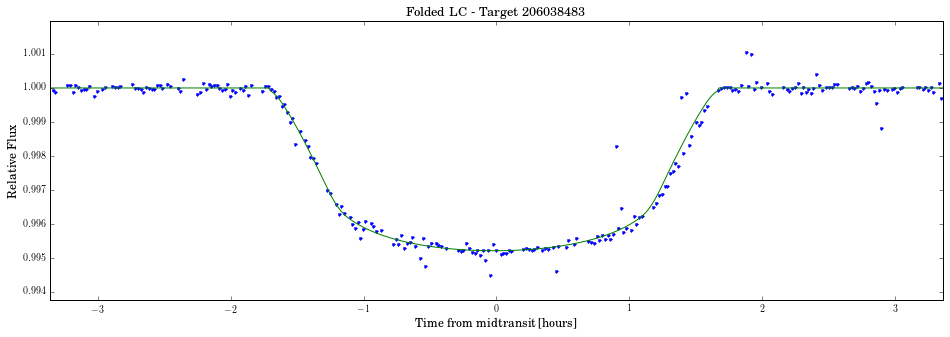

Optimization for target 206061524 ...
Optimization terminated successfully.
         Current function value: -753.612617
         Iterations: 473
         Function evaluations: 729
-> Optimal parameters:
      Depth: 0.00772800504943
      Impact parameter b: 0.400328803444
      Initial transit time: 0.000450213662337
      Sum of quadratic LD coefficients: 0.571613252978
      Sigma (additional white noise term): 6.66480515573e-08
      Mass (Earth units): 0.649116714907
      Radius (Earth units): 0.622292960899
      Out-of-transit Flux: 0.999978734921



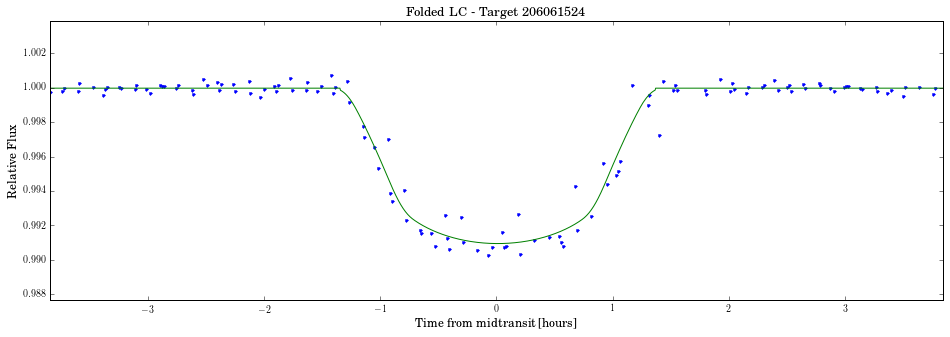

Optimization for target 206082454 ...
Optimization terminated successfully.
         Current function value: -351.822778
         Iterations: 326
         Function evaluations: 502
-> Optimal parameters:
      Depth: 0.000964681381505
      Impact parameter b: 0.052123672221
      Initial transit time: 6.97971181492e-05
      Sum of quadratic LD coefficients: 0.999989041186
      Sigma (additional white noise term): 2.98458708518e-10
      Mass (Earth units): 0.904897821404
      Radius (Earth units): 0.855165021471
      Out-of-transit Flux: 1.00001831398



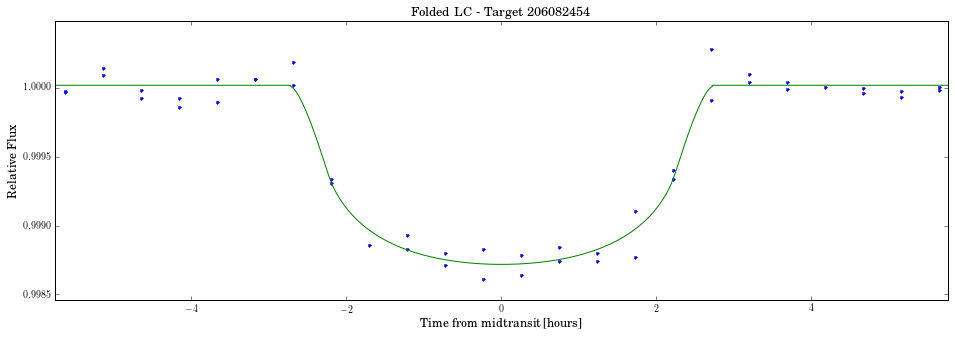

Optimization for target 206155547 ...
Optimization terminated successfully.
         Current function value: -380.559597
         Iterations: 796
         Function evaluations: 1162
-> Optimal parameters:
      Depth: 0.0217511245745
      Impact parameter b: 0.527799772877
      Initial transit time: -6.66856522451e-05
      Sum of quadratic LD coefficients: 0.526832457446
      Sigma (additional white noise term): 4.03894225174e-08
      Mass (Earth units): 1.18026409427
      Radius (Earth units): 1.23593279177
      Out-of-transit Flux: 1.00000531312



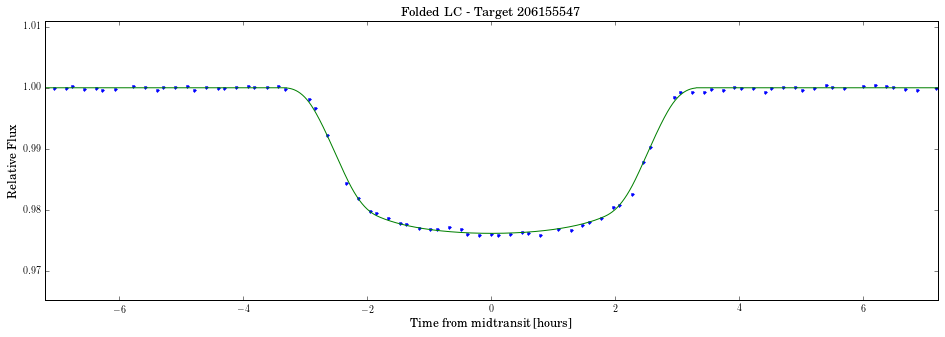

Optimization for target 206245553 ...
Optimization terminated successfully.
         Current function value: -922.857105
         Iterations: 479
         Function evaluations: 749
-> Optimal parameters:
      Depth: 0.000494931354345
      Impact parameter b: 0.395603642885
      Initial transit time: 0.000183422048197
      Sum of quadratic LD coefficients: 0.740968009385
      Sigma (additional white noise term): 3.45659809884e-11
      Mass (Earth units): 1.07068037533
      Radius (Earth units): 1.09019954548
      Out-of-transit Flux: 0.999998498507



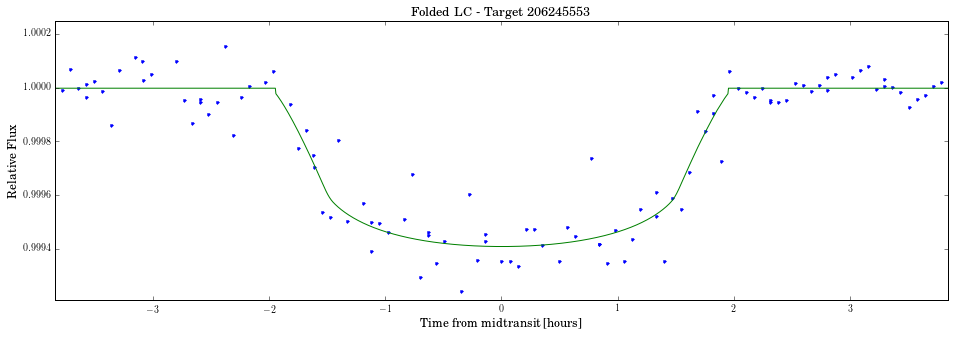

In [22]:
for star in new_targets:
    print "Optimization for target", star.name, "..."
    
    #Upload clean folded light curve 
    data = pd.read_table('4_folded' + star.name +'.csv', delimiter=' ', header = None, names=['time', 'flux', 'error'])
    
    star.dt = data['time']
    star.f_trans = data['flux']
    
    # Upload best guesses obtained in Part 1:
    parameters_ml = np.loadtxt('1_'+ star.name +'guesses.txt', skiprows=1)
    depth_ml = parameters_ml[0]
    b_ml = parameters_ml[1]
    t0_ml = parameters_ml[2]
    sigma_ml = parameters_ml[3]
    sumLD_ml = parameters_ml[4]
    mass_ml = parameters_ml[5]
    radius_ml = parameters_ml[6]
    f0_ml = parameters_ml[7]
 
    # Fixed Variables: 
    allfixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
 
    #Optimize parameters
    n3 = lambda *args: -lnprob(*args)
    result = op.minimize(n3, [depth_ml, np.abs(b_ml), 0.0, sigma_ml, 0.6, mass_ml, radius_ml, f0_ml], 
                         args = (star.dt, star.f_trans, star.error_foldedLC, allfixed), 
                         options={'disp': True}, 
                         method='Nelder-Mead')
    
    # Store and print the new best estimates 
    depth_ml2, b_ml2, t0_ml2, sigma_ml2, sumLD_ml2, mass_ml2, radius_ml2, f0_ml2 = result["x"]

    star.optimize4 = result["x"]
    
    print "-> Optimal parameters:"
    print "      Depth:", depth_ml2
    print "      Impact parameter b:", b_ml2
    print "      Initial transit time:", t0_ml2
    print "      Sum of quadratic LD coefficients:", sumLD_ml2
    print "      Sigma (additional white noise term):", sigma_ml2
    print "      Mass (Earth units):", mass_ml2
    print "      Radius (Earth units):", radius_ml2
    print "      Out-of-transit Flux:", f0_ml2
    print ""

    #Update coefficients
    u1_ml2 = 0.5*(sumLD_ml2 + star.diffld)
    u2_ml2 = sumLD_ml2-u1_ml2
    
    #Update  parameters
    star.u1 = u1_ml2
    star.u2 = u2_ml2
    star.mass = mass_ml2
    star.radius = radius_ml2
    star.depth = depth_ml2
    star.b = b_ml2 
    
    # Compute each transit LC integrated over a Kepler long cadence exposure time with 
    #the result derived from optimization and plot theoretical model and observed data.
    
    s = transit.System(transit.Central(mu1 = star.u1, mu2 = star.u2, mass = star.mass, radius = star.radius))
    
    body = transit.Body(r = np.sqrt(star.depth)*star.radius, period = star.per, 
                        t0 = t0_ml2, b = np.abs(star.b), e = star.ecc)
    s.add_body(body)

    t_theory = np.arange(-1, 1, tKep*0.01)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-08, maxdepth = 4)
    f_theory = f_theory - 1.0 + f0_ml2

    fig = plt.figure(figsize=(16,5))
    plt.plot(24.0*star.dt, star.f_trans, '.') #Plot folded LC (note: dt is now in hours)
    plt.plot(24.0*t_theory, f_theory)
    plt.title('Folded LC - Target ' + star.name, fontsize = 13)
    plt.xlabel('Time from midtransit [hours]', fontsize = 12)
    plt.ylabel('Relative Flux', fontsize = 12)
    plt.xlim([-star.transWindow*24.0, star.transWindow*24.0]) 
    plt.ylim([1-star.depth*1.6, star.depth*0.5+1]) 
    plt.savefig('4_'+star.name+'model_foldedLC.png', dpi = 700)
    plt.show()

## Final MCMC

With the best fit solutions, we'll run an MCMC routine to estimate the uncertainties on the parameters.

Analysis of: 201516974
Model parameters:
      Depth: 0.00271751833174
      Impact parameter b: 0.899533936536
      Initial transit time: 0.00082387717287
      Sigma: 1.66256784235e-10
      Sum of quadratic LD coefficients: 0.740164461632
      Mass (Earth units): 0.0111186275555
      Radius (Earth units): 1.51722615862
      Out-of-transit Flux: 1.0000220203

Running MCMC...
Done.


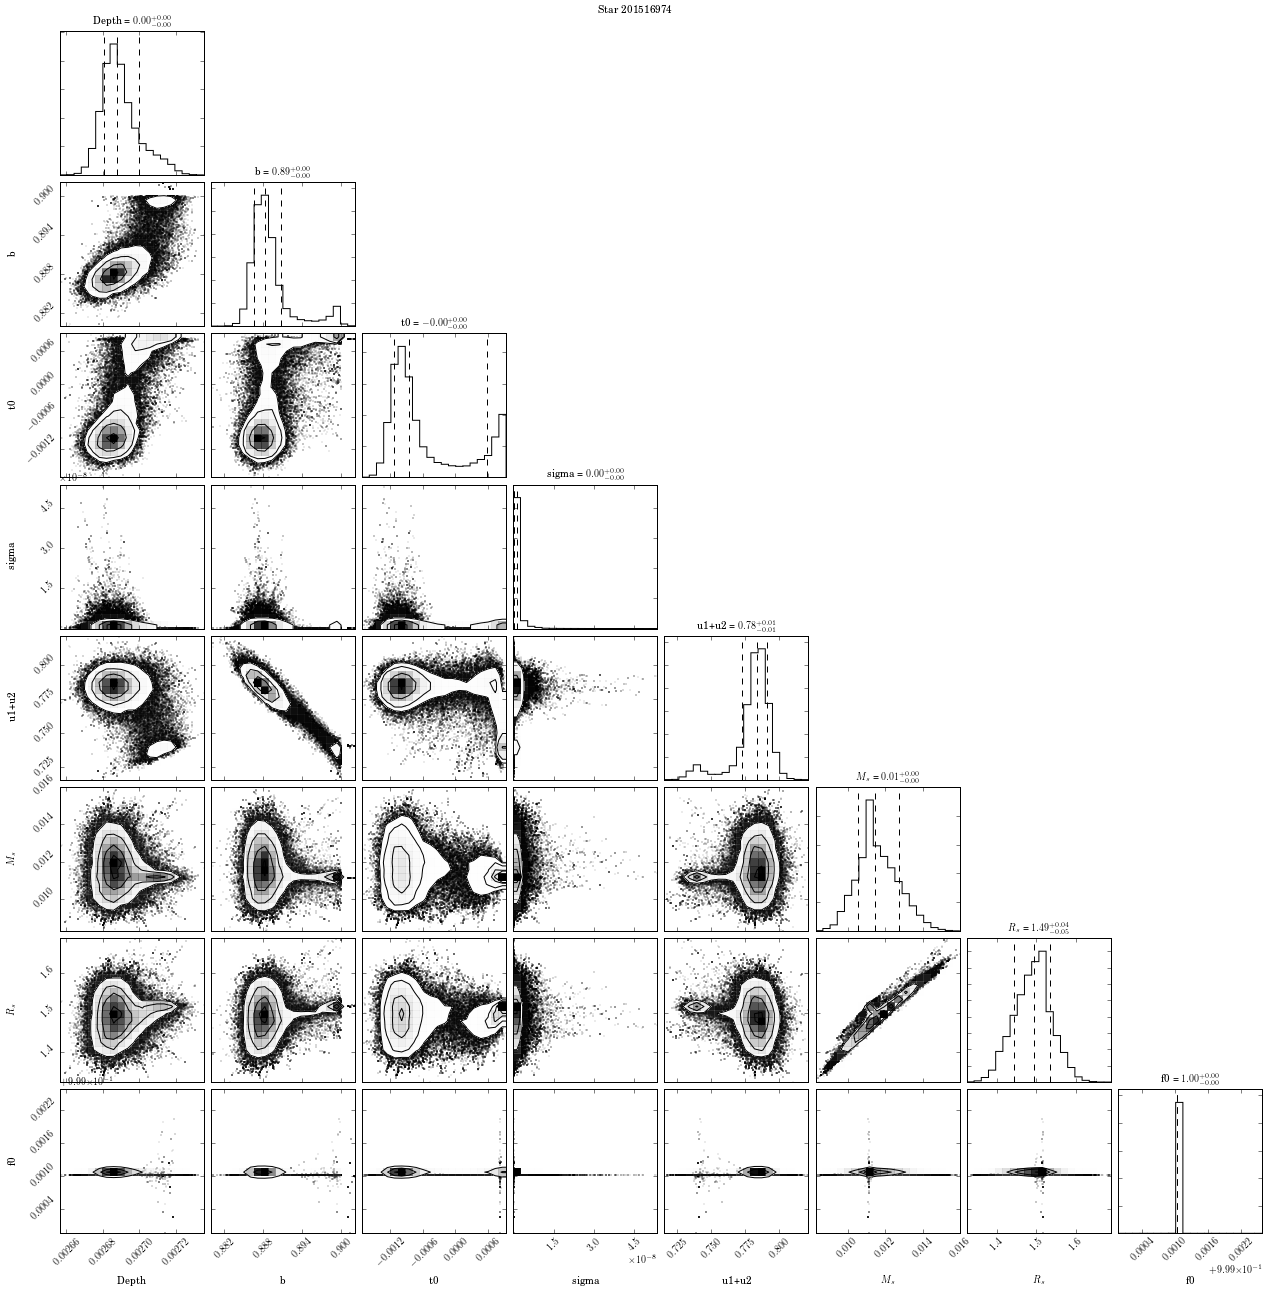

Mean acceptance fraction: 0.377

Autocorrelation time: [ 78.93800443  70.93705352  86.84335004  73.54808892  66.80910073
  81.59495204  55.64580263  32.31373148]
(8.4476567417474655, 0.23379882575082966, 0.29396770465965361)
(0.14145331654813942, 0.0010717481071098878, 0.00066167451698634361)

----------------------------------------------------------------------------------------------------
Analysis of: 201920032
Model parameters:
      Depth: 0.000592460446765
      Impact parameter b: 0.0167855463211
      Initial transit time: -0.000578256473632
      Sigma: 2.10796369624e-06
      Sum of quadratic LD coefficients: 0.999391815655
      Mass (Earth units): 0.995058046583
      Radius (Earth units): 0.809194384782
      Out-of-transit Flux: 1.00002119169

Running MCMC...
Done.


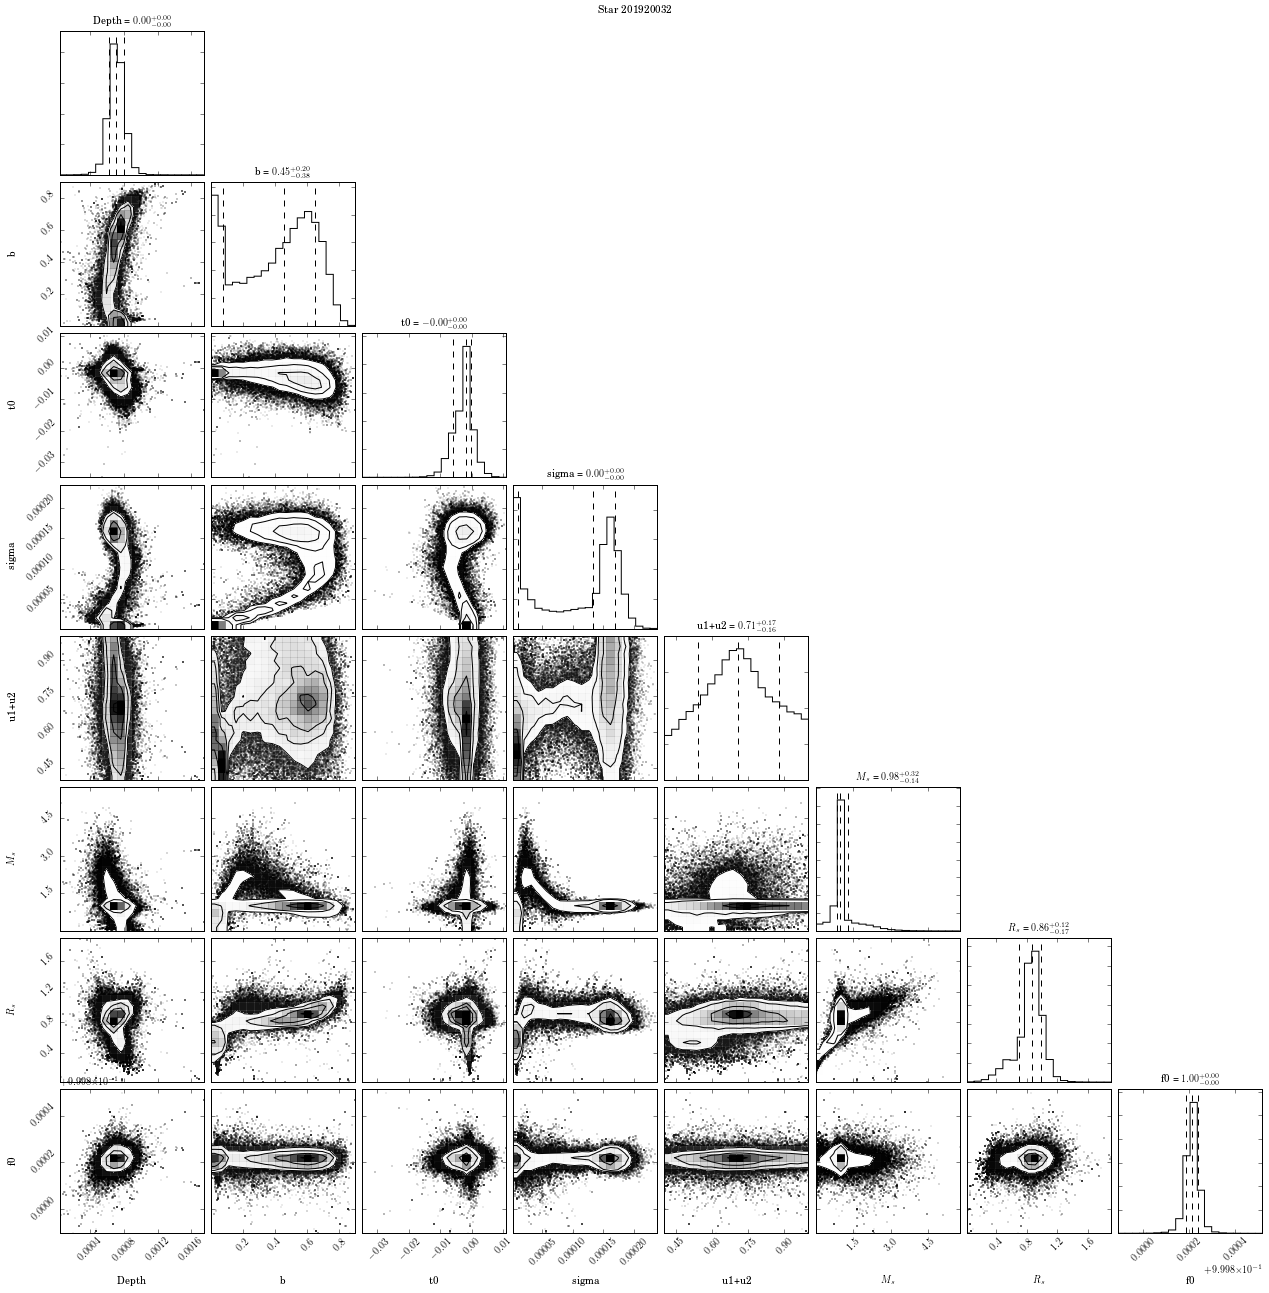

Mean acceptance fraction: 0.398

Autocorrelation time: [ 59.29790228  85.85656328  82.68348039  89.37438185  49.25489769
  60.96889842  75.58017709  20.58362361]
(2.4679171976691729, 0.43638180970408724, 0.51470168141636474)
(0.021338797033637211, 0.0031568145844582708, 0.0034711738839600173)

----------------------------------------------------------------------------------------------------
Analysis of: 205924614
Model parameters:
      Depth: 0.00302519638264
      Impact parameter b: 0.10981115186
      Initial transit time: -1.02926748022e-06
      Sigma: 8.22099482524e-07
      Sum of quadratic LD coefficients: 0.758184840149
      Mass (Earth units): 0.70421754217
      Radius (Earth units): 0.669997829823
      Out-of-transit Flux: 0.999998429073

Running MCMC...
Done.


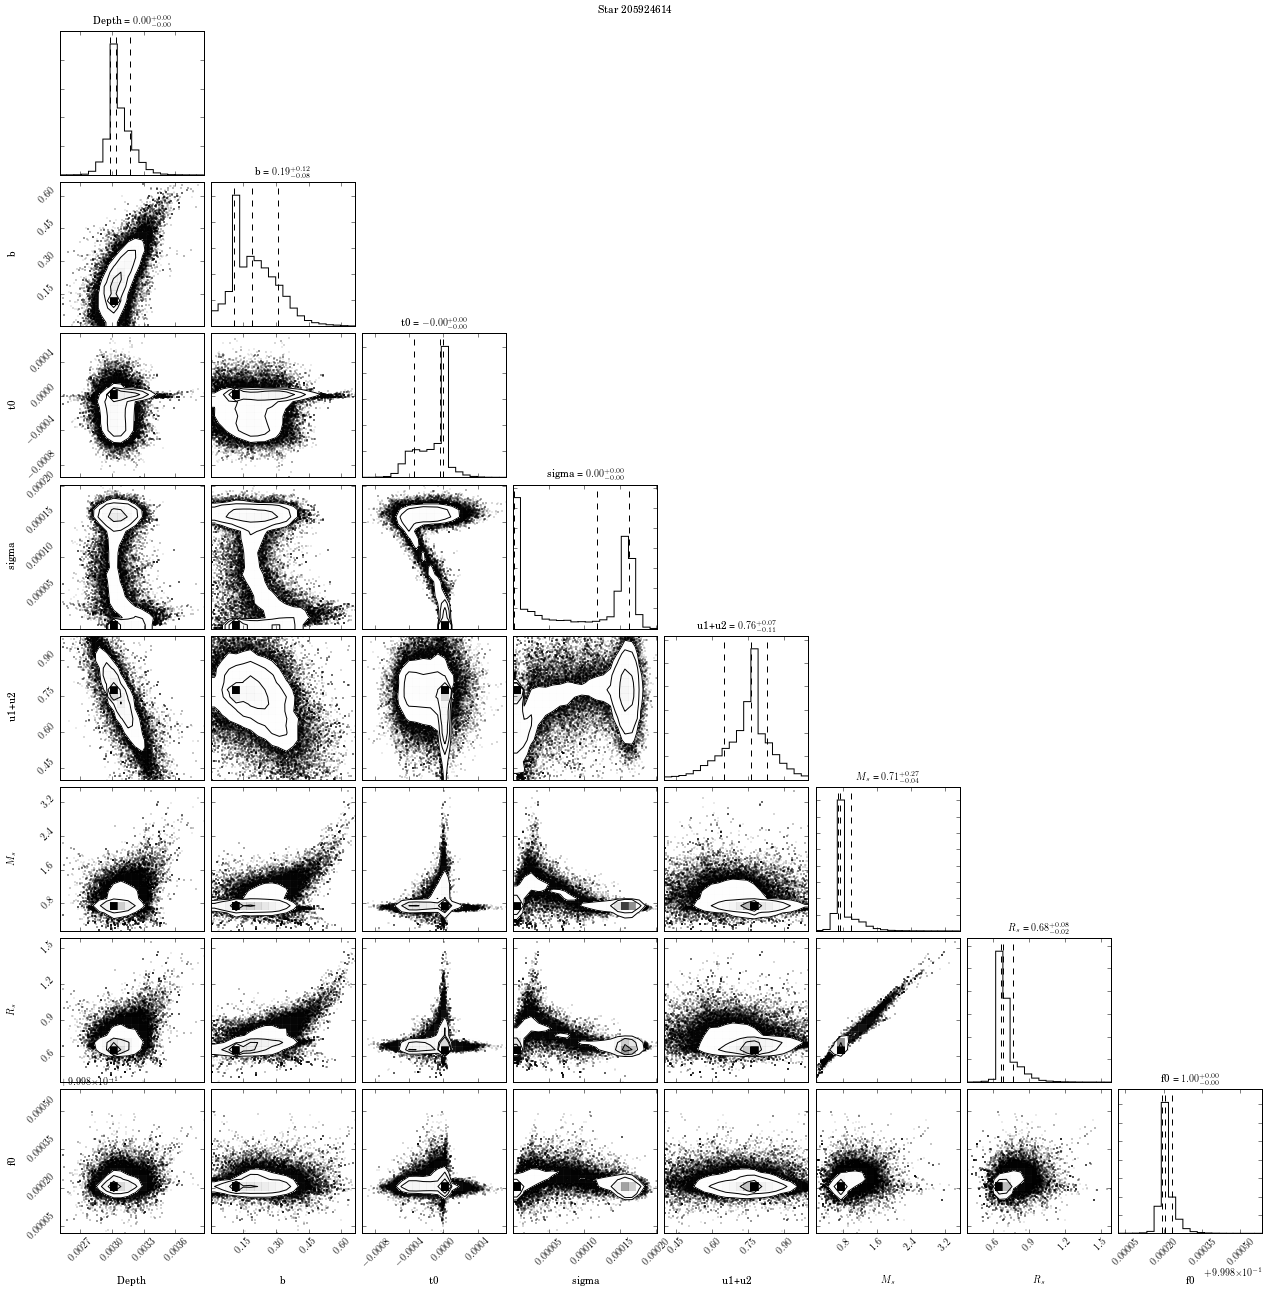

Mean acceptance fraction: 0.399

Autocorrelation time: [ 62.96266243  72.42100643  84.93297769  90.23752456  69.50208442
  75.75255253  74.82897147  81.43080425]
(4.1211620630212851, 0.53774671841074273, 0.12439871862790008)
(0.090489359186737894, 0.0026267937818091058, 0.0012779943330179788)

----------------------------------------------------------------------------------------------------
Analysis of: 206029314
Model parameters:
      Depth: 0.0271122490298
      Impact parameter b: 0.0262564120485
      Initial transit time: 0.00148658551799
      Sigma: 0.000157761044664
      Sum of quadratic LD coefficients: 0.400163121414
      Mass (Earth units): 0.772699163972
      Radius (Earth units): 1.05926780875
      Out-of-transit Flux: 0.99868490816

Running MCMC...
Done.


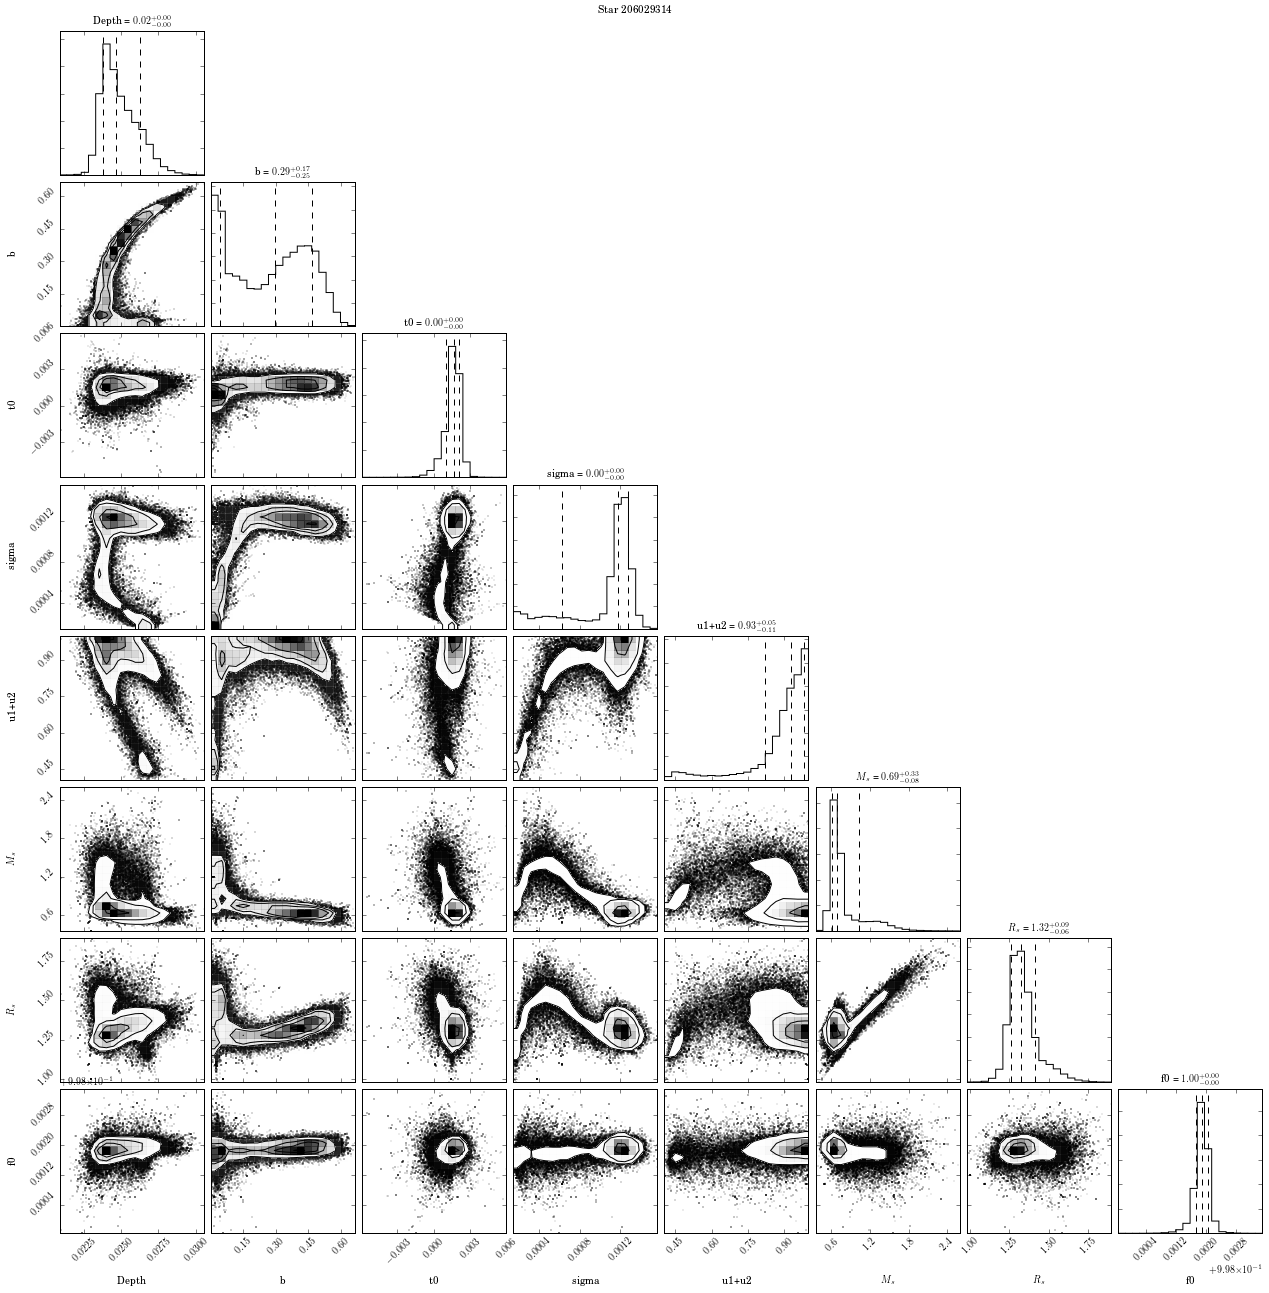

Mean acceptance fraction: 0.387

Autocorrelation time: [ 72.35372867  87.45785431  82.8457501   81.58004678  68.55979223
  79.55727924  51.25171909  62.63665961]
(22.759680598699845, 2.0383536703071954, 1.3884943696518164)
(0.094676150019951305, 0.0072002926447368443, 0.0055812468706043783)

----------------------------------------------------------------------------------------------------
Analysis of: 206038483
Model parameters:
      Depth: 0.00390410053669
      Impact parameter b: 3.40288841849e-06
      Initial transit time: -0.000754796048387
      Sigma: 2.38613651392e-06
      Sum of quadratic LD coefficients: 0.692151231987
      Mass (Earth units): 0.973632339171
      Radius (Earth units): 1.08528412478
      Out-of-transit Flux: 0.999995249934

Running MCMC...
Done.


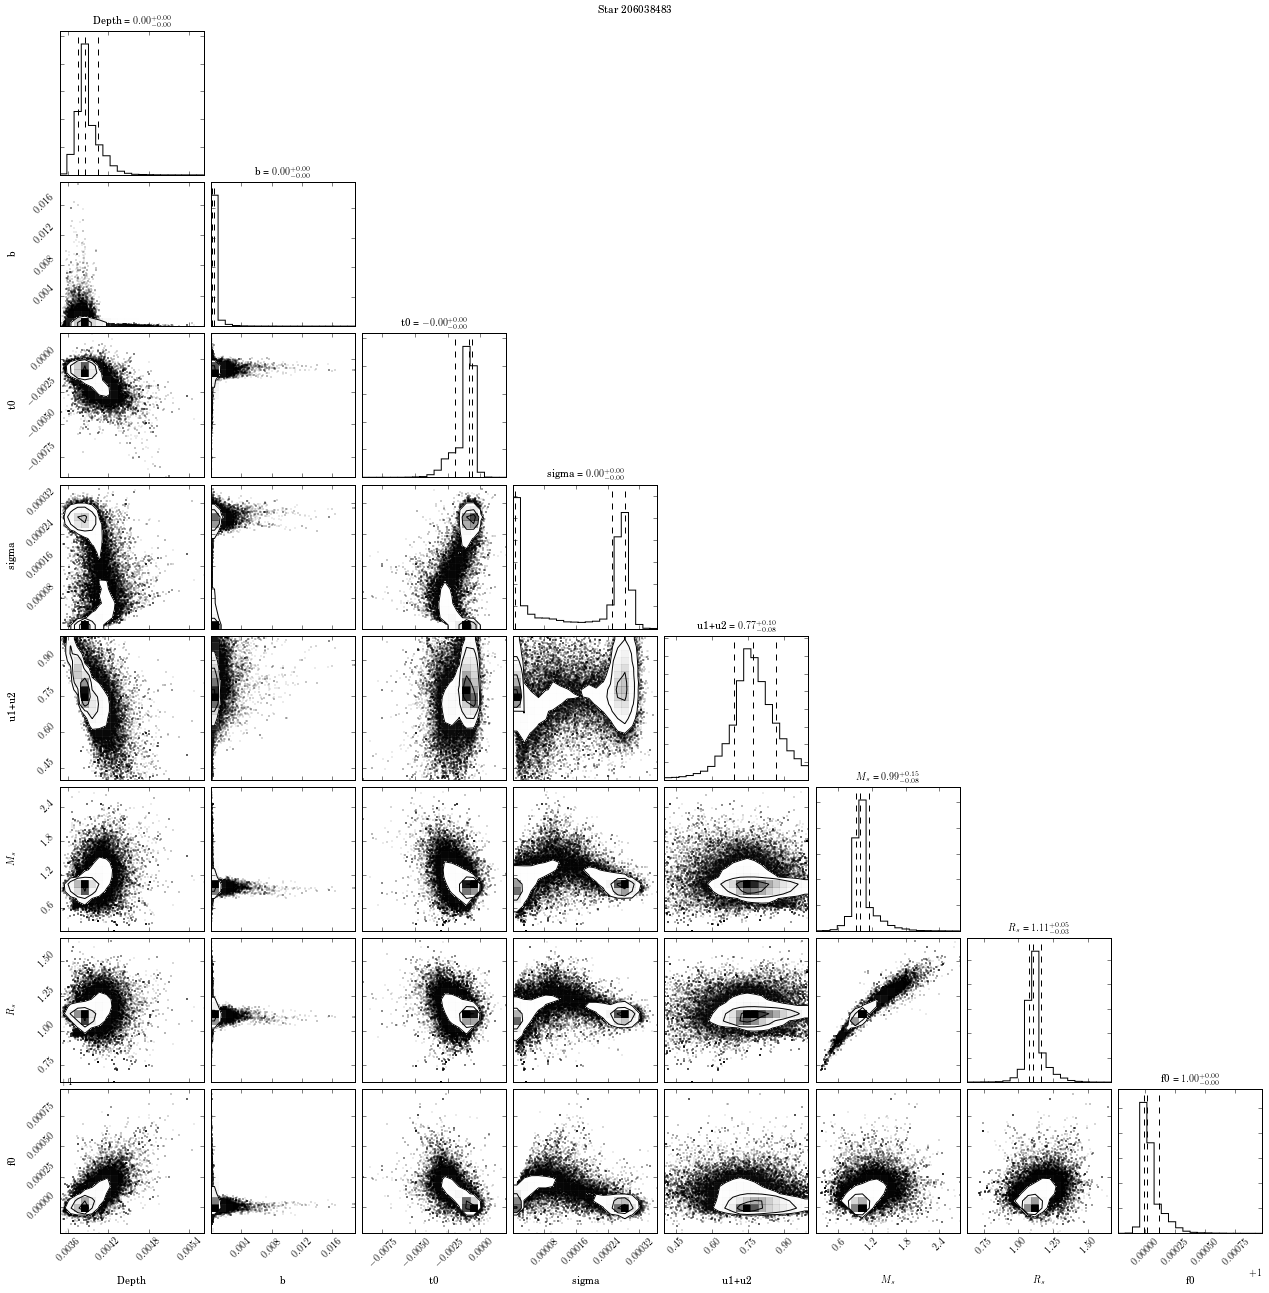

Mean acceptance fraction: 0.418

Autocorrelation time: [ 82.62456453  69.0287506   80.18834458  89.76916338  62.93464996
  73.98446645  71.86803626  81.12800619]
(7.4803281712823395, 0.50788427012396475, 0.20936600616063039)
(0.12677642770472297, 0.0018506802033258496, 0.0014841039862909799)

----------------------------------------------------------------------------------------------------
Analysis of: 206061524
Model parameters:
      Depth: 0.00772800504943
      Impact parameter b: 0.400328803444
      Initial transit time: 0.000450213662337
      Sigma: 6.66480515573e-08
      Sum of quadratic LD coefficients: 0.571613252978
      Mass (Earth units): 0.649116714907
      Radius (Earth units): 0.622292960899
      Out-of-transit Flux: 0.999978734921

Running MCMC...
Done.


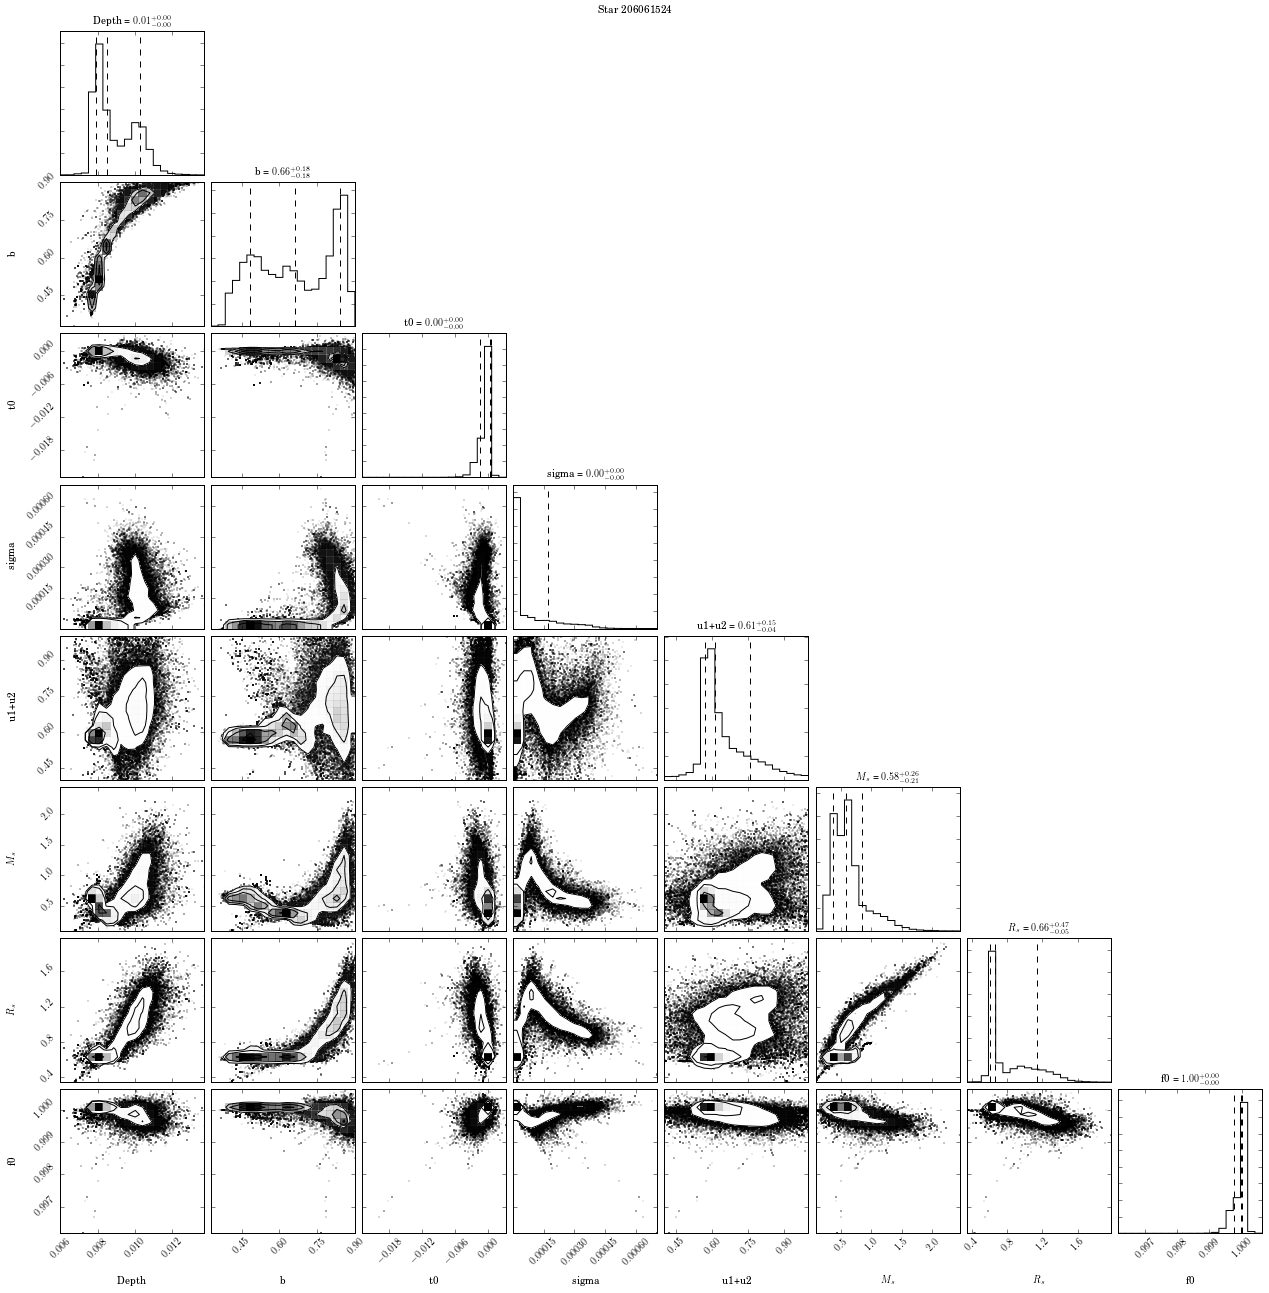

Mean acceptance fraction: 0.344

Autocorrelation time: [ 89.54528274  88.14834995  89.716202    73.68721831  78.36936782
  78.33978554  88.55056219  78.42231441]
(6.4881884282994147, 6.0093153685463445, 0.5158287196165503)
(0.064371143221275101, 0.024172087509139489, 0.009516916135055703)

----------------------------------------------------------------------------------------------------
Analysis of: 206082454
Model parameters:
      Depth: 0.000964681381505
      Impact parameter b: 0.052123672221
      Initial transit time: 6.97971181492e-05
      Sigma: 2.98458708518e-10
      Sum of quadratic LD coefficients: 0.999989041186
      Mass (Earth units): 0.904897821404
      Radius (Earth units): 0.855165021471
      Out-of-transit Flux: 1.00001831398

Running MCMC...
Done.


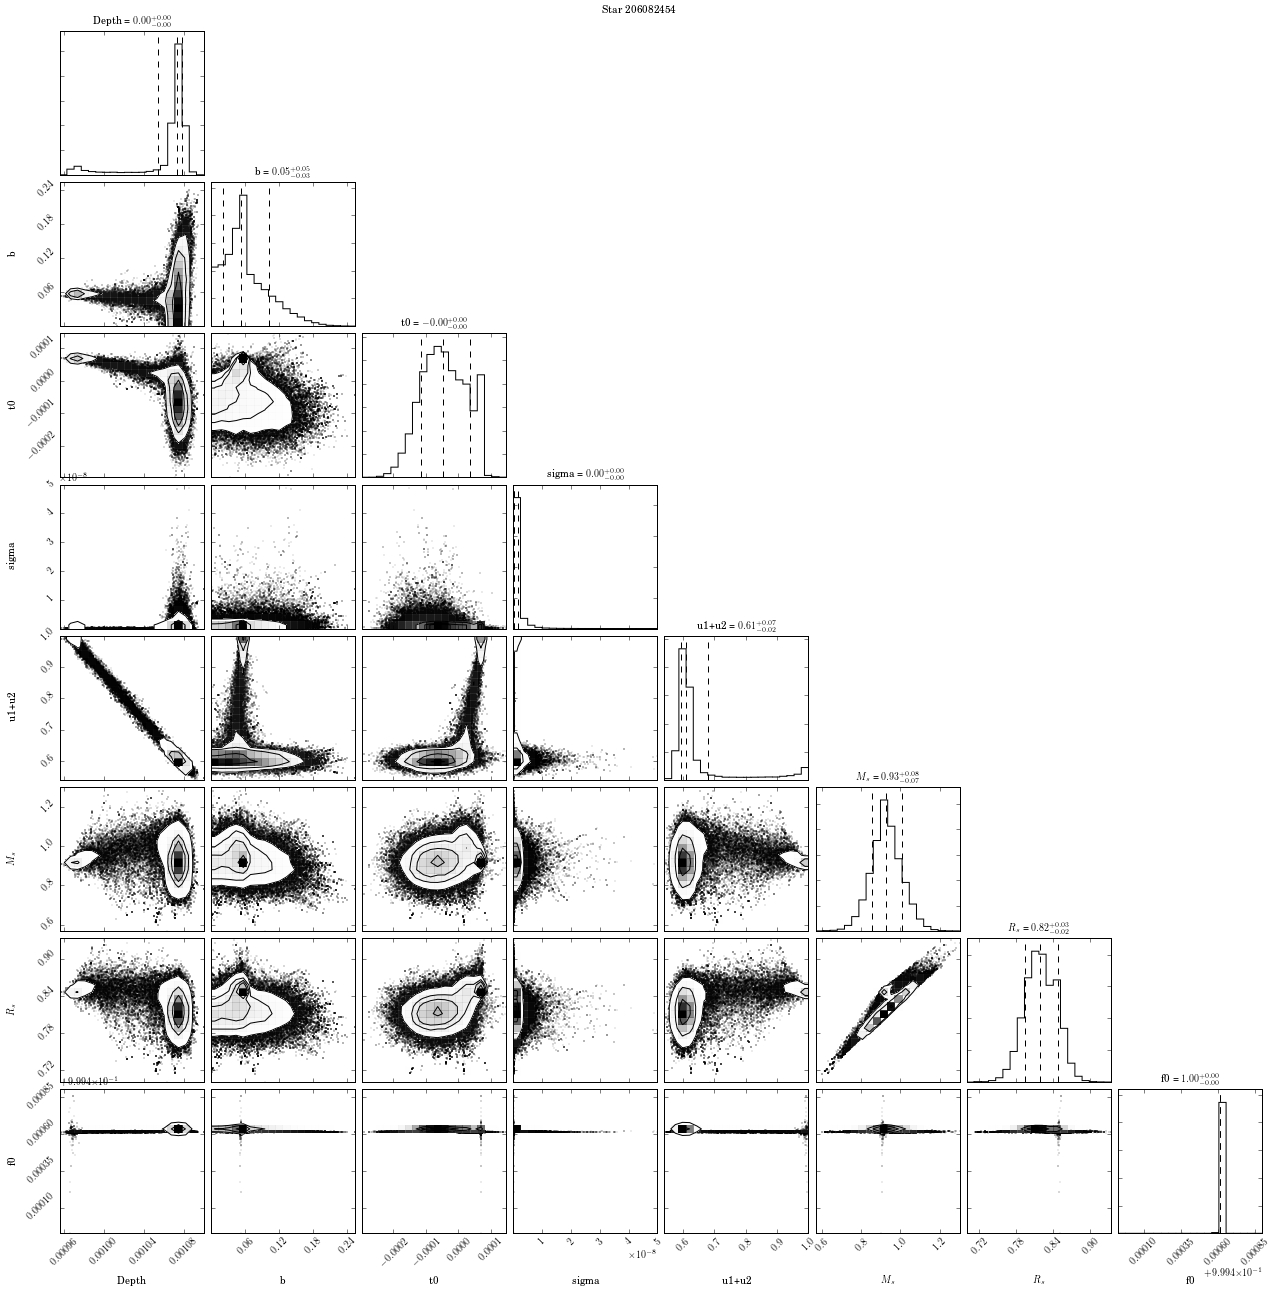

Mean acceptance fraction: 0.361

Autocorrelation time: [ 74.44187933  87.32846132  85.88798354  73.77601779  74.42147872
  80.19566181  84.41504382  49.63452562]
(2.9104558933031486, 0.082241724385800019, 0.07389710919284731)
(0.020779697583061262, 0.00021141361854147556, 6.6322295719307284e-05)

----------------------------------------------------------------------------------------------------
Analysis of: 206155547
Model parameters:
      Depth: 0.0217511245745
      Impact parameter b: 0.527799772877
      Initial transit time: -6.66856522451e-05
      Sigma: 4.03894225174e-08
      Sum of quadratic LD coefficients: 0.526832457446
      Mass (Earth units): 1.18026409427
      Radius (Earth units): 1.23593279177
      Out-of-transit Flux: 1.00000531312

Running MCMC...
Done.


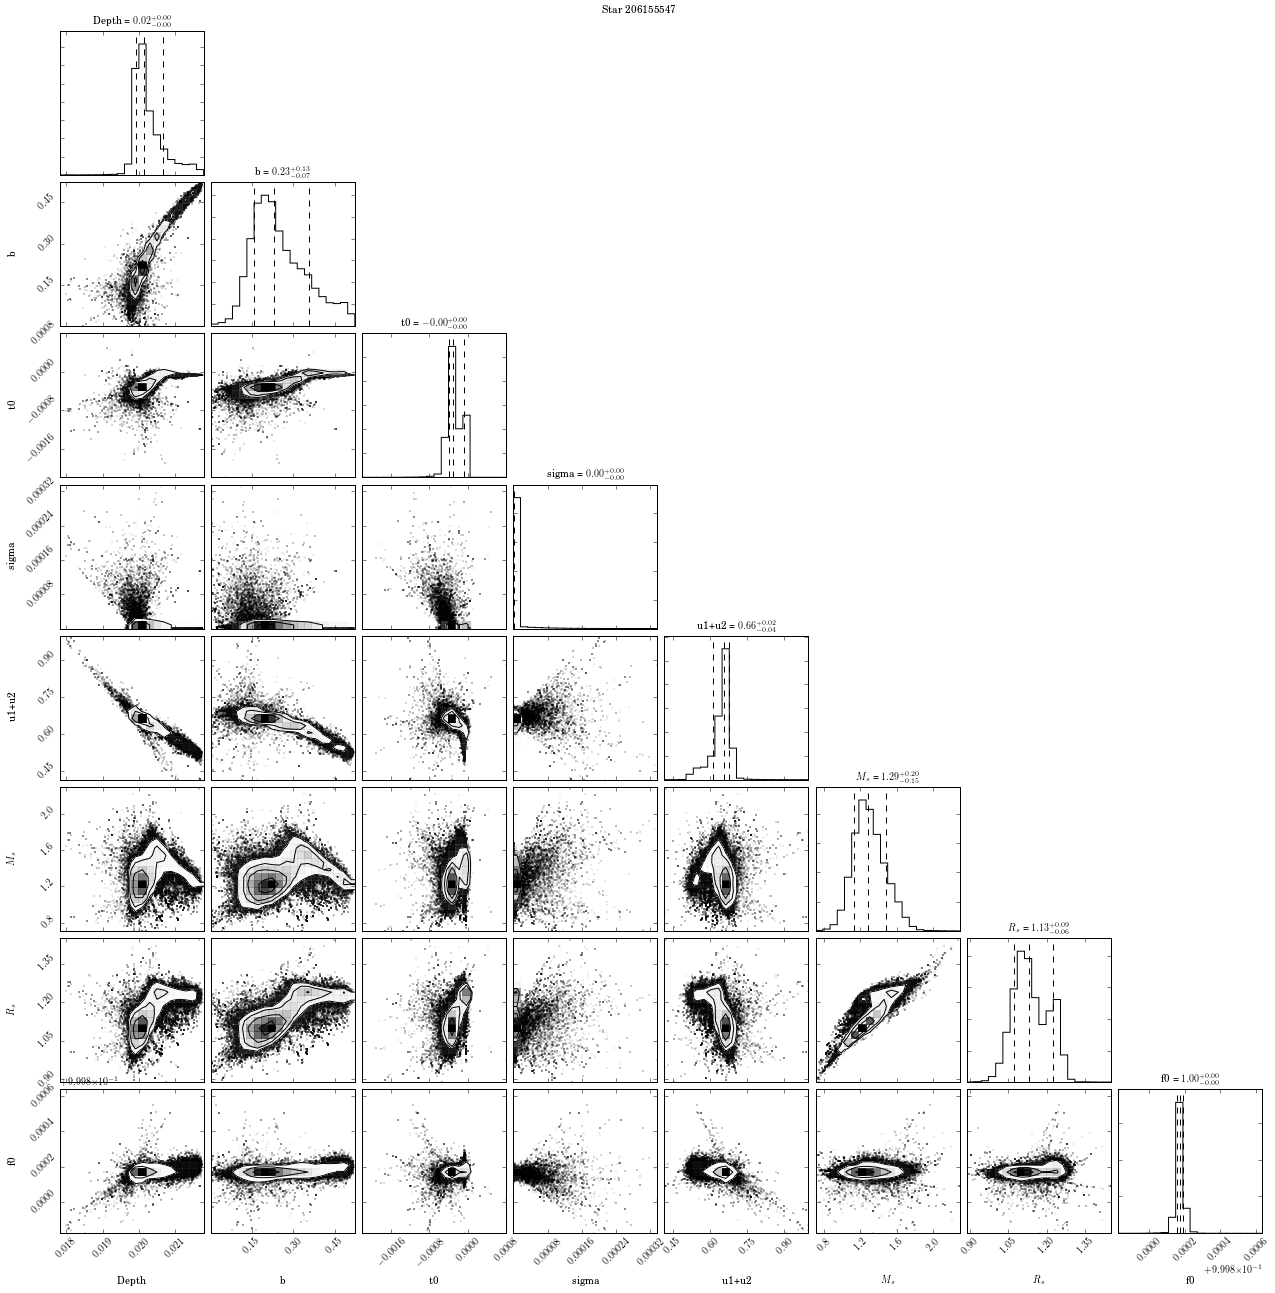

Mean acceptance fraction: 0.383

Autocorrelation time: [ 76.1695124   80.8936495   82.76949745  26.18346977  76.35676967
  81.35055419  89.27948364  67.2910841 ]
(17.470404411353289, 1.7908152665830315, 0.93069190147335235)
(0.029266487251088276, 0.0010767703280182075, 0.00038210516221624108)

----------------------------------------------------------------------------------------------------
Analysis of: 206245553
Model parameters:
      Depth: 0.000494931354345
      Impact parameter b: 0.395603642885
      Initial transit time: 0.000183422048197
      Sigma: 3.45659809884e-11
      Sum of quadratic LD coefficients: 0.740968009385
      Mass (Earth units): 1.07068037533
      Radius (Earth units): 1.09019954548
      Out-of-transit Flux: 0.999998498507

Running MCMC...
emcee: Exception while calling your likelihood function:
  params: [  4.93556592e-04   3.89045026e-01   1.83896764e-04   3.34266494e-11
   7.51678335e-01   1.09939296e+00   1.10106245e+00   9.99999523e-01]
  args: (0  

Traceback (most recent call last):
  File "/Users/mbadenas/anaconda/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-145-0f86e41269e5>", line 5, in lnprob
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)
  File "<ipython-input-143-bced123459e5>", line 25, in lnlike
    ftheo = s.light_curve(timeLC, texp = tKep, tol = 1e-8, maxdepth = 4)
  File "/Users/mbadenas/anaconda/lib/python2.7/site-packages/transit/transit.py", line 424, in light_curve
    np.radians(iy), texp, tol, maxdepth)
KeyboardInterrupt


KeyboardInterrupt: 

In [147]:
G = 6.6730e-11

for star in new_targets:   
    print "Analysis of:", star.name
    print "Model parameters:" 
    print "      Depth:", star.optimize4[0]
    print "      Impact parameter b:", star.optimize4[1]
    print "      Initial transit time:", star.optimize4[2]        
    print "      Sigma:", star.optimize4[3]
    print "      Sum of quadratic LD coefficients:", star.optimize4[4]
    print "      Mass (Earth units):", star.optimize4[5]
    print "      Radius (Earth units):", star.optimize4[6]
    print "      Out-of-transit Flux:", star.optimize4[7]
    print ""

    allfixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
    
    # We'll sample a 8-dimensional Gaussian with "nwalkers" walkers.
    ndim = 8
    nwalkers = 500
    st = 500
    burnin = 50 # Burn in
    
    # Choose an initial set of positions for the walkers.
    p0 = [star.optimize4*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

    # Initialize the sampler with the chosen specs.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                    lnprob, 
                                    args = (star.dt, star.f_trans, 0.01*star.error_foldedLC, allfixed))

    # Run 100 steps as a burn-in starting from our initial guess p0. Generally a good idea to run a few “burn-in” steps in your MCMC chain to let the walkers explore the parameter space a bit and get settled into the maximum of the density.
    pos, prob, state = sampler.run_mcmc(p0, burnin) 
    
    # Reset the chain to remove the burn-in samples. 
    sampler.reset()  
    
    # Starting from the final position in the burn-in chain, sample for "steps" steps.
    print("Running MCMC...")
    sampler.run_mcmc(pos, st, rstate0 = state)
    print("Done.")
    
    # "sampler.chain" is an array with the shape (nwalkers, st, ndim). A more useful object is the 
    # "sampler.flatchain", which has the shape (nwalkers*st, ndim) and contains all the
    #  samples reshaped into a flat list. We will now have nwalkers*st unbiased samples of the density p(x). 
    
    samples = sampler.chain[:, 25:, :].reshape((-1, ndim)) 

    # Make a corner plot to visualize projection of samples in multidimensional space. Get an estimate of 
    # the density that we were sampling. 
    
    plt.figure()
    figure = corner.corner(samples, labels=["Depth", "b", "t0", "sigma", "u1+u2", "$M_s$","$R_s$", "f0"], 
                           quantiles = [0.16, 0.5, 0.84], show_titles = True, title_args={"fontsize": 13})

    figure.gca().annotate('Star '+star.name, xy = (0.5, 1.0), 
                          xycoords="figure fraction", xytext=(0, -5), 
                          textcoords="offset points", ha = "center", va="top")

    fig.savefig('4_'+star.name+'_corner.png', dpi = 700)    
    plt.show()
              
    # Print out the mean acceptance fraction. In general, acceptance_fraction has an entry for each walker so, 
    # in this case, it is a "nwalker"-dimensional vector. 
    # This nº should be b/w approx. 0.25 & 0.5 if everything 
    # went as planned.
    
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))) 
    print ""
    
    # Estimate the autocorrelation time for the chain. This is also a vector with 8 entries (one for each dimension of parameter space).
    
    print "Autocorrelation time:", sampler.acor
     
    # Calculate the uncertainties based on the 16, 50th, and 84th percentiles of the samples in 
    # the marginalized distributions.         

    samples[:, 3] = np.sqrt(samples[:, 3]**2 + 0.01*star.error_foldedLC**2) # I added this line so that the reported uncertainty is the full error of the flux (error_foldedLC was just a guess). 

    # Infer properties of the system
    
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]
    P1 = star.per*24.0*3600.0
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

    depth_mcmc, b_mcmc, t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.84, 50, 84.16], axis=0)))

    v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

    v = np.percentile(r_asamp, [16, 50, 84], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

    print planetrad_mcmc # The planet radius in units of the Earth's radius and its +- errors.
    print r_a_mcmc # The inverse of the scaled semi-major axis

    np.savetxt('4_'+star.name+'finalparams.txt', 
               (depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc, planetrad_mcmc, r_a_mcmc), fmt='%.11f', delimiter='   ', header = """Parameters obtained from fitting the Kepler data. 
                           The 1st column represents the 50% percentile of the MCMC posterior distribution. The 2nd and 3rd show the +1 and -1 sigma errors, respectively. 
                           In row order, the parameters are: Depth, Impact parameter, time of transit, sigma (full error), 
                           Sum of LD coefficients, Mass of the star in Earth units, Radius of the star in  earth units (gaussian priors on both), 
                           out of eclipse flux, Planet radius (Earth units), R_s/a (Inverse of scaled semi-major axis)""")
    
    print ""
    print "----------------------------------------------------------------------------------------------------"